In [ ]:
from google.colab import files
uploaded = files.upload()


Saving netflix_titles.csv to netflix_titles.csv


In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv('netflix_titles.csv')

# Show missing values per column
missing_summary = df.isnull().sum()
print("Missing values in each column:\n", missing_summary)

# Fill missing categorical values with mode
for col in df.select_dtypes(include='object').columns:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)

# Fill numeric columns with median (if any)
for col in df.select_dtypes(include='number').columns:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

# Drop rows where more than 50% of the values are missing
threshold = len(df.columns) / 2
df.dropna(thresh=threshold, inplace=True)

# Confirm cleanup
print("\n✅ After Cleaning:")
print(df.isnull().sum())


Missing values in each column:
 show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

✅ After Cleaning:
show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64


<ipython-input-2-4bd0913c1648>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [ ]:
# Step 2: Identify duplicate rows
duplicate_rows = df[df.duplicated()]
print(f"🔍 Total duplicate rows: {duplicate_rows.shape[0]}")

# Remove duplicates and keep the first occurrence
df = df.drop_duplicates()
print(f"✅ Shape after dropping duplicates: {df.shape}")

# Optionally, remove duplicates based on specific columns (e.g., 'title' and 'release_year')
# df = df.drop_duplicates(subset=['title', 'release_year'])


🔍 Total duplicate rows: 0
✅ Shape after dropping duplicates: (8807, 12)


In [ ]:
# Convert the 'date_added' column to a standard 'YYYY-MM-DD' format
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce').dt.strftime('%Y-%m-%d')

# Display unique formats to confirm conversion
print(df['date_added'].head())


0    2021-09-25
1    2021-09-24
2    2021-09-24
3    2021-09-24
4    2021-09-24
Name: date_added, dtype: object


In [ ]:
# Convert 'title', 'director', and 'cast' to uppercase, trim spaces, and remove special characters
def clean_text_column(df, col):
    df[col] = df[col].str.upper()  # Convert to uppercase
    df[col] = df[col].str.strip()   # Remove leading and trailing spaces
    df[col] = df[col].str.replace('[^A-Za-z0-9 ]', '', regex=True)  # Remove special characters
    return df

# Clean the relevant columns
df = clean_text_column(df, 'title')
df = clean_text_column(df, 'director')
df = clean_text_column(df, 'cast')

# Check cleaned columns
print(df[['title', 'director', 'cast']].head())


                   title         director  \
0   DICK JOHNSON IS DEAD  KIRSTEN JOHNSON   
1           BLOOD  WATER    RAJIV CHILAKA   
2              GANGLANDS  JULIEN LECLERCQ   
3  JAILBIRDS NEW ORLEANS    RAJIV CHILAKA   
4           KOTA FACTORY    RAJIV CHILAKA   

                                                cast  
0                                 DAVID ATTENBOROUGH  
1  AMA QAMATA KHOSI NGEMA GAIL MABALANE THABANG M...  
2  SAMI BOUAJILA TRACY GOTOAS SAMUEL JOUY NABIHA ...  
3                                 DAVID ATTENBOROUGH  
4  MAYUR MORE JITENDRA KUMAR RANJAN RAJ ALAM KHAN...  


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Ensure column names are clean
df.columns = df.columns.str.strip()

# Convert categorical columns with fewer than 10 unique values to one-hot encoding
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    if col not in df.columns:  # Check if the column exists
        print(f"Column {col} does not exist!")
        continue  # Skip this column if it doesn't exist

    if len(df[col].unique()) < 10:
        df = pd.get_dummies(df, columns=[col], prefix=[col], drop_first=True)
    else:
        label_encoder = LabelEncoder()
        df[col] = label_encoder.fit_transform(df[col])

# Show final dataset sample
print(df.head())



   show_id  title  director  cast  country  date_added  release_year  rating  \
0        0   1961      2293  1702      603        1698        2020.0       7   
1     1111   1082      3398   411      426        1697        2021.0      11   
2     2222   2634      2108  6310      603        1697        2021.0      11   
3     3333   3495      3398  1702      603        1697        2021.0      11   
4     4444   3855      3398  4828      251        1697        2021.0      11   

   duration  listed_in  description  type_TV Show  
0       210        274         2577         False  
1       110        414         1762          True  
2         0        242         7341          True  
3         0        297         3617          True  
4       110        393         4416          True  


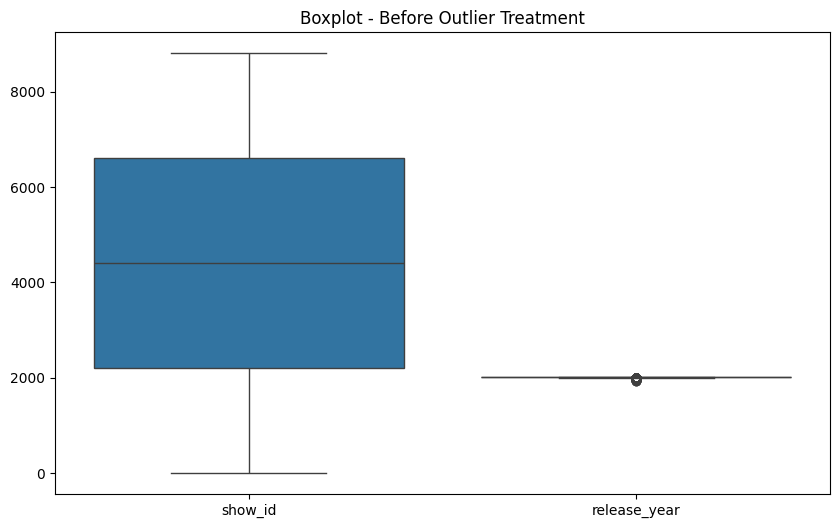

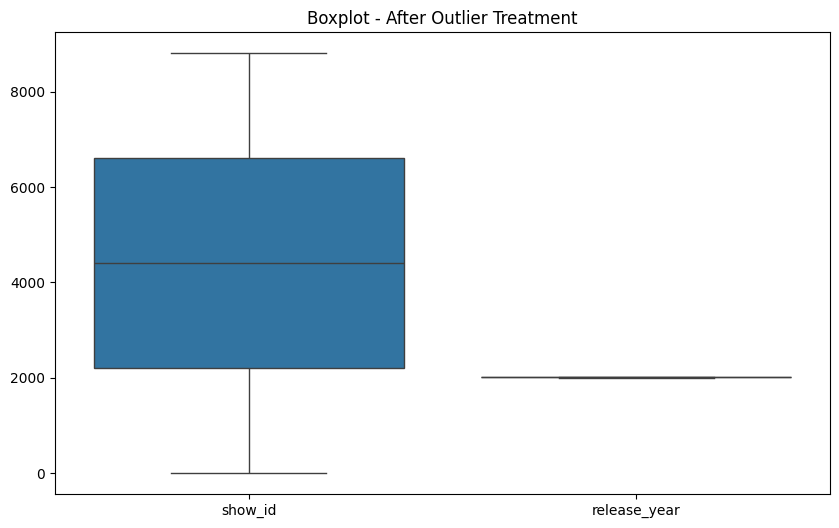

In [ ]:
# Step 4: Outlier Detection using IQR (Interquartile Range)

import matplotlib.pyplot as plt
import seaborn as sns

# Identify numerical columns
numerical_cols = df.select_dtypes(include='number').columns

# Visualize the boxplots before treatment
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[numerical_cols])
plt.title('Boxplot - Before Outlier Treatment')
plt.show()

# Calculate the IQR for each numerical column
Q1 = df[numerical_cols].quantile(0.25)
Q3 = df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace outliers with the lower and upper bounds
for col in numerical_cols:
    df[col] = df[col].apply(lambda x: lower_bound[col] if x < lower_bound[col] else (upper_bound[col] if x > upper_bound[col] else x))

# Visualize the boxplots after treatment
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[numerical_cols])
plt.title('Boxplot - After Outlier Treatment')
plt.show()


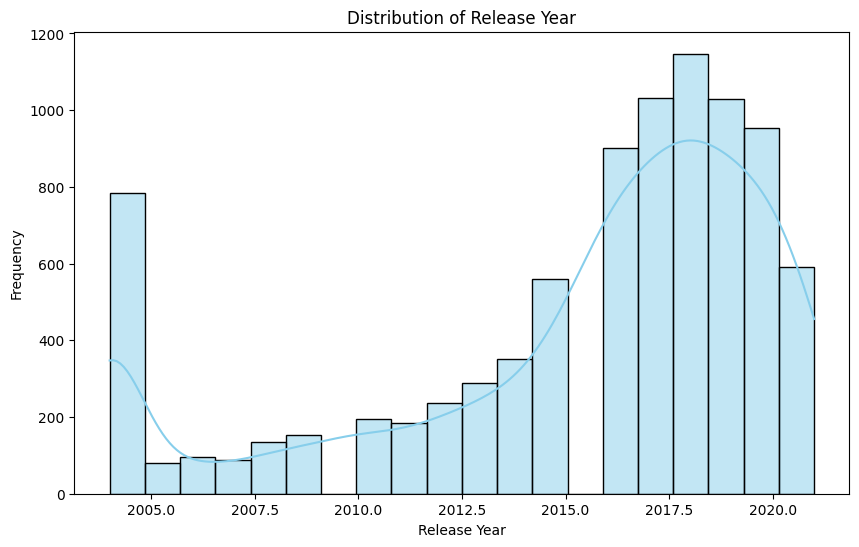

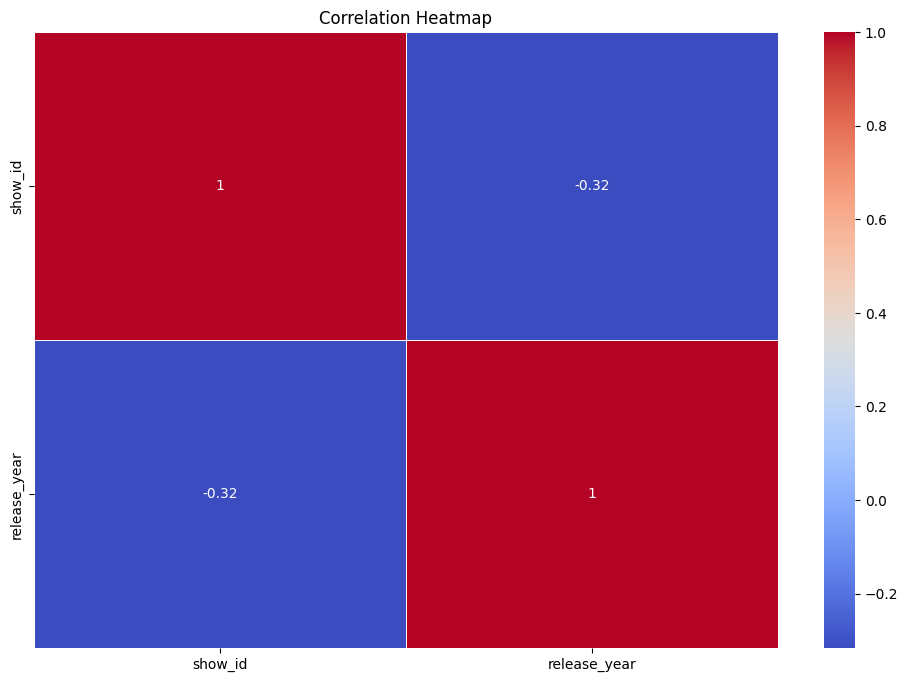

<ipython-input-9-16c38c57f9dd>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rating', y='title', data=top_rated, palette='viridis')


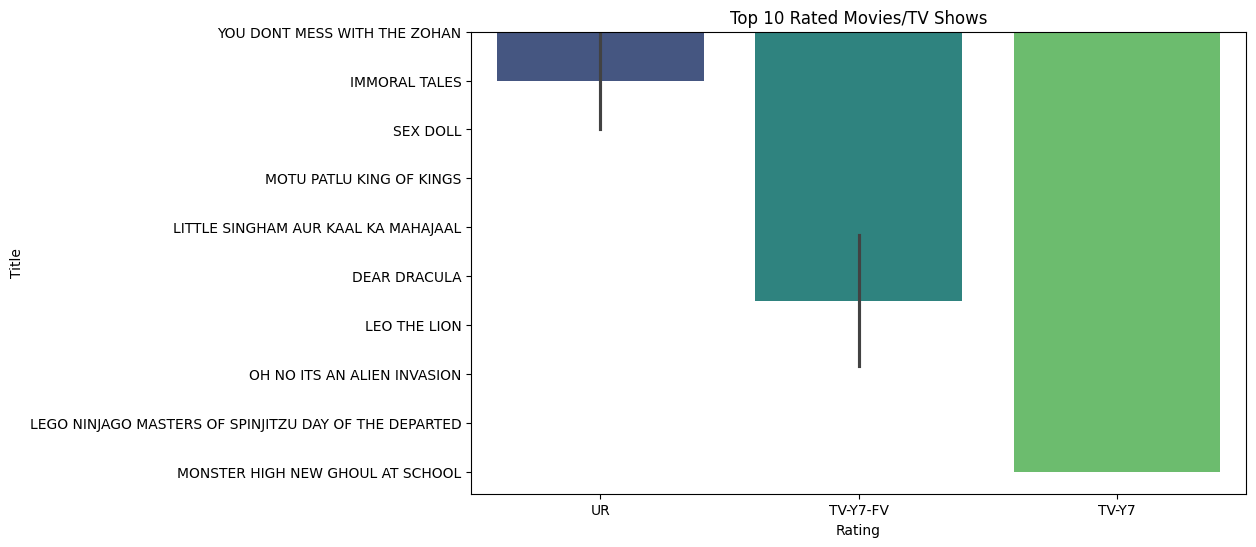

'genre' column not found!


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Clean column names: Remove leading/trailing spaces if any
df.columns = df.columns.str.strip()

# Step 5: Data Visualization

# 1. Distribution of Numerical Features (e.g., Rating, Release Year)
if 'release_year' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df['release_year'], kde=True, bins=20, color='skyblue')
    plt.title('Distribution of Release Year')
    plt.xlabel('Release Year')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("'release_year' column not found!")

# 2. Correlation Heatmap for Numerical Features
numerical_cols = df.select_dtypes(include='number').columns
if len(numerical_cols) > 0:
    corr_matrix = df[numerical_cols].corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Heatmap')
    plt.show()
else:
    print("No numerical columns found!")

# 3. Top-rated Movies/TV Shows based on Rating
if 'title' in df.columns and 'rating' in df.columns:
    top_rated = df[['title', 'rating']].sort_values(by='rating', ascending=False).head(10)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='rating', y='title', data=top_rated, palette='viridis')
    plt.title('Top 10 Rated Movies/TV Shows')
    plt.xlabel('Rating')
    plt.ylabel('Title')
    plt.show()
else:
    print("'title' or 'rating' column not found!")

# 4. Most Common Genres (Assuming we have a 'genre' column)
if 'genre' in df.columns:
    genre_counts = df['genre'].value_counts().head(10)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='Set2')
    plt.title('Top 10 Most Common Genres')
    plt.xlabel('Genre')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("'genre' column not found!")
